# Data Vault Demo (Dev -- Full Access)

The basic concept of the Data Vault is that when a user authenticates themself, they receive an engine that gives them access to all the data (rows, columns, tables, schema, etc.) for which they are authorized.  Users who can authenticate themselves for multiple roles can use those roles simultaneously.  We are keeping in mind the importance of Data Lineage Management (tracked by issue https://github.com/os-climate/os_c_data_commons/issues/50) but is not treated as part of this particular prototype.

The steps of this demo are:

1. **Authenticate and acquire SQLAlchemy engine**
    1. **Dev engine sees all**
    2. Quant engine can do temp scoring but not see fundamental company info
    3. User engine can use temp scoring but not see cumulative emissions nor overshoot info
2. **With Dev engine, construct Vaults for:**
    1. **Fundamental corporate financial information**
    2. **Corporate emissions data (base year, historical)**
    3. **Corporate target data (start year, end year, target start value, target end value)**
    4. **Sector benchmark data (production, CO2e intensity)**
3. **Dev Engine: Visualize projected emissions (targets and trajectories) and calculate cumulative emissions**
4. Quant Engine: Using calculated cumulative emmisions, visualize per-company trajectory and target temperature scores
5. User Engine: Using consensus probability scoring and own portfolio data (ISIN, position value)
    1. Calculate publishable per-company temperature alignment score
    2. Based on aggregate corporate and portfolio information, produce weighting scores to yield overall portfolio alignment score

In [1]:
import os
import pathlib
from dotenv import load_dotenv

# Load some standard environment variables from a dot-env file, if it exists.
# If no such file can be found, does not fail, and so allows these environment vars to
# be populated in some other way
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

import trino
from sqlalchemy.engine import create_engine

### Step 1: Initialize Vaut user 'Dev', which has full visibility into corporate financial, production, and target data

In [2]:
sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ['TRINO_USER_USER1'],
    host = os.environ['TRINO_HOST'],
    port = os.environ['TRINO_PORT']
)

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'demo_dv'

sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ['TRINO_PASSWD_USER1']),
    'http_scheme': 'https',
    'catalog': ingest_catalog,
    'schema': ingest_schema,
}

engine_dev = create_engine(sqlstring, connect_args = sqlargs)
print("connecting with engine " + str(engine_dev))
connection_dev = engine_dev.connect()
engine_dev.execute(f"show tables in {ingest_schema}").fetchall()

connecting with engine Engine(trino://os-climate-user1@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/)


/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/sqlalchemy_trino/dialect.py:259: SAWarning: Dialect trino:rest will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  res = connection.execute(sql.text(query)).scalar()


[('benchmark_ei',),
 ('benchmark_prod',),
 ('company_data',),
 ('cumulative_budget_1',),
 ('cumulative_emissions',),
 ('emissions_data',),
 ('isic_to_sector',),
 ('oecm_cumprod',),
 ('overshoot_ratios',),
 ('production_data',),
 ('target_data',),
 ('temperature_scores',),
 ('trajectory_data',)]

### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

In [3]:
import json
import pandas as pd
from numpy.testing import assert_array_equal
import ITR

# from ITR.portfolio_aggregation import PortfolioAggregationMethod
# from ITR.temperature_score import TemperatureScore
# from ITR.configs import ColumnsConfig, TemperatureScoreConfig
# from ITR.data.data_warehouse import DataWarehouse
from ITR.data.vault_providers import VaultCompanyDataProvider, VaultProviderProductionBenchmark, \
    VaultProviderIntensityBenchmark, DataVaultWarehouse
# from ITR.interfaces import ICompanyData, EScope, ETimeFrames, PortfolioCompany, IEIBenchmarkScopes, \
#     IProductionBenchmarkScopes
from ITR.interfaces import EScope, IProductionBenchmarkScopes, IEIBenchmarkScopes

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/sqlalchemy_trino/dialect.py:259: SAWarning: Dialect trino:rest will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  res = connection.execute(sql.text(query)).scalar()


### Step 2: construct vaults for corporate financial, production, and target information.

We also create benchmark data (which is presumed public information).  There's more work to be done to modularly add new benchmarks that automatically become available options to to the ITR tool.

In this demo we read ITR benchmark data from JSON files (REST API-friendly).  Such data coming from the notebook filesystem is "untethered" data.  The corporate data comes from an existing data pipeline (in this case, the pipeline processing RMI data).  When data comes from the data commons, it is "tethered" to the Data Commons.  The Data Vault can only control access to data that goes through the Data Commons via 'engines'.

In [4]:
root = root = os.path.dirname(os.getcwd()+ '/../test/')
benchmark_prod_json = os.path.join(root, "inputs", "json", "benchmark_production_OECM.json")
benchmark_EI_json = os.path.join(root, "inputs", "json", "benchmark_EI_OECM.json")

# load production benchmarks
with open(benchmark_prod_json) as json_file:
    parsed_json = json.load(json_file)
prod_bms = IProductionBenchmarkScopes.parse_obj(parsed_json)
vault_production_bm = VaultProviderProductionBenchmark(engine=engine_dev, benchmark_name="benchmark_prod", production_benchmarks=prod_bms)

# load intensity benchmarks
with open(benchmark_EI_json) as json_file:
    parsed_json = json.load(json_file)
ei_bms = IEIBenchmarkScopes.parse_obj(parsed_json)
vault_EI_bm = VaultProviderIntensityBenchmark(engine=engine_dev, benchmark_name="benchmark_ei", EI_benchmarks=ei_bms)

# load company data
# TODO: Pandas reads null data mixed with integers as float64 (np.nan).  This can be fixed post hoc with astype('Int16')
vault_company_data = VaultCompanyDataProvider(engine=engine_dev, company_table="company_data")

vault_warehouse = DataVaultWarehouse(engine_dev, vault_company_data, vault_production_bm, vault_EI_bm)

year           Int64
production    object
region        string
sector        string
scope         string
dtype: object
Index(['year', 'production', 'region', 'sector', 'scope'], dtype='object')
RangeIndex(start=0, stop=192, step=1)
constructed fully qualified table name as: "demo_dv.benchmark_prod"
inserting 192 records
  (2019, 0.0, 'dimensionless', 'Global', 'Steel', 'S1S2')
  (2020, 0.015, 'dimensionless', 'Global', 'Steel', 'S1S2')
  (2021, 0.015, 'dimensionless', 'Global', 'Steel', 'S1S2')
  ...
  (2050, 0.0032269880188280364, 'dimensionless', 'North America', 'Electricity Utilities', 'S1S2')
batch insert result: [(192,)]
year               Int64
intensity         object
region            string
sector            string
scope             string
global_budget     object
benchmark_temp    object
dtype: object
Index(['year', 'intensity', 'region', 'sector', 'scope', 'global_budget',
       'benchmark_temp'],
      dtype='object')
RangeIndex(start=0, stop=192, step=1)
constructed full

### Step 3: Visualize Emissions, Targets, and Trajectories

SuperSet Dashboard here (not really, not yet, but points to TRINO_USER dashboard, not TRINO_USER1 dashboard): https://superset-secure-odh-superset.apps.odh-cl2.apps.os-climate.org/superset/dashboard/4/?edit=true&native_filters=%28%29

Plot emissions data.  Others can be plotted by following same pattern.

Note that without units, a company that emits 80 t CO2e/t Steel looks like it might emit a lot more than one that emits 10t CO2e/MWh.  With units, it becomes clear that the 80 and the 10 are not comparable.

In [5]:
# Because this DF comes from reading a Trino table, and because columns must be unqiue, we don't have to enumerate to ensure we properly handle columns with duplicated names

def requantify_df(df: pd.DataFrame) -> pd.DataFrame:
    units_col = None
    columns_reversed = reversed(df.columns)
    for col in columns_reversed:
        if col.endswith("_units"):
            if units_col:
                # We expect _units column to follow a non-units column
                raise ValueError
            units_col = col
            continue
        if units_col:
            if col + '_units' != units_col:
                raise ValueError
            if (df[units_col]==df[units_col][0]).all():
                # Make a PintArray
                new_col = PintArray(df[col], dtype=f"pint[{ureg(df[units_col][0]).u}]")
            else:
                # Make a pd.Series of Quantity in a way that does not throw UnitStrippedWarning
                new_col = pd.Series(data=df[col], name=col) * pd.Series(data=df[units_col].map(lambda x: ureg(x).u), name=col)
            df = df.drop(columns=units_col)
            df[col] = new_col
            units_col = None
    return df

In [6]:
from ITR.data.osc_units import *
ureg.setup_matplotlib()
import numpy as np
sql_df = pd.read_sql_table(f"emissions_data", engine_dev)
sql_df

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'partition' was not located in columns for table 'emissions_data'
  tbl = Table(
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'record_count' was not located in columns for table 'emissions_data'
  tbl = Table(
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'file_count' was not located in columns for table 'emissions_data'
  tbl = Table(
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'total_size' was not located in columns for table 'emissions_data'
  tbl = Table(
/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pandas/io/sql.py:1773: SAWarning: index key 'data' was not located in columns for table 'emissions_data'
  tbl = Table(


,company_name,company_lei,company_id,sector,year,co2_s1_by_year,co2_s1_by_year_units,co2_s2_by_year,co2_s2_by_year_units
0,Tri-State Generation & Transmission Associatio...,549300VDHNFNPADSSV98,ZZ00000000180,Electricity Utilities,2030,4.047107e+00,CO2 * megametric_ton,0.0,CO2 * megametric_ton
1,UNITED STATES STEEL CORP,JNLUVFYJT1OZSIQ24U47,US9129091081,Steel,2030,2.600000e+07,CO2 * metric_ton,2640000.0,CO2 * metric_ton
2,Valtec Power,RMI00000000000000015,ZZ00000000015,Electricity Utilities,2030,0.000000e+00,CO2 * megametric_ton,0.0,CO2 * megametric_ton
3,WEC Energy Group,549300IGLYTZUK3PVP70,US92939U1060,Electricity Utilities,2030,7.166047e+00,CO2 * megametric_ton,0.0,CO2 * megametric_ton
4,WORTHINGTON INDUSTRIES INC,1WRCIANKYOIK6KYE5E82,US9818111026,Steel,2030,1.259577e+05,CO2 * metric_ton,123170.6,CO2 * metric_ton
...,...,...,...,...,...,...,...,...,...
2216,Sempra,PBBKGKLRK5S5C0Y4T545,US8168511090,Electricity Utilities,2016,9.332563e-01,CO2 * megametric_ton,0.0,CO2 * megametric_ton
2217,Southern Co.,549300FC3G3YU2FBZD92,US8425871071,Electricity Utilities,2016,7.315806e+01,CO2 * megametric_ton,0.0,CO2 * megametric_ton
2218,TENARIS SA,549300Y7C05BKC4HZB40,US88031M1099,Steel,2016,2.000000e+06,CO2 * metric_ton,1000000.0,CO2 * metric_ton
2219,TERNIUM S.A.,529900QG4KU23TEI2E46,US8808901081,Steel,2016,1.774456e+07,CO2 * metric_ton,858941.0,CO2 * metric_ton


In [7]:
df = requantify_df(sql_df.dropna())
df.co2_s1_by_year = df.co2_s1_by_year.astype('pint[t CO2]')
df.co2_s2_by_year = df.co2_s2_by_year.astype('pint[t CO2]')

In [8]:
df.dtypes

company_name                      object
company_lei                       object
company_id                        object
sector                            object
year                               int64
co2_s1_by_year    pint[CO2 * metric_ton]
co2_s2_by_year    pint[CO2 * metric_ton]
dtype: object

In [9]:
df = df.sort_values(['company_name', 'year']).reset_index(drop=True)

/Users/michael/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


<AxesSubplot:xlabel='year', ylabel='CO2·metric_ton'>

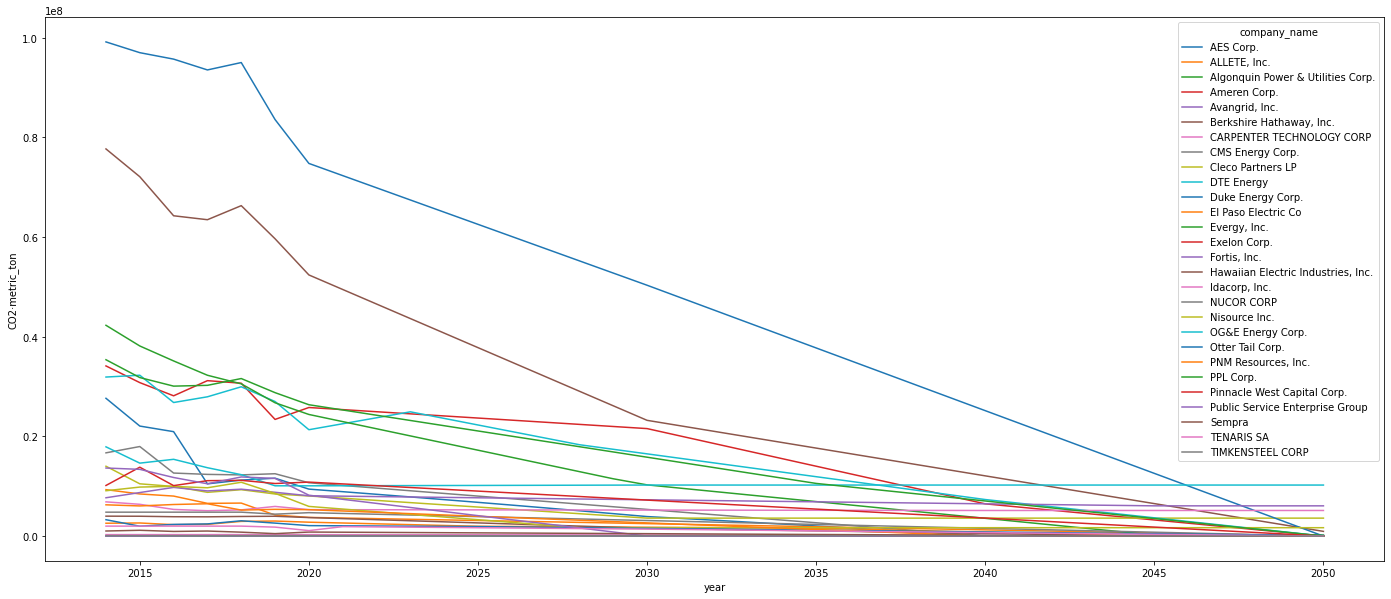

In [10]:
plottable_df = df.pivot(index='year', columns='company_name', values='co2_s1_by_year').reset_index()

# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.iloc[:, [x for x in list(range(0,3)) + list(range(3,55,2))]].plot(x='year', kind='line', figsize=(24,10))

### Step 4: Use Quant engine to access and visualize temperature scores

When the Data Vault is ready to be implemented, we can demonstrate that the Quant engine does not have access to primary company data (neither financial nor production)

Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

### Step 5: Show per-company temperature score and weighted portfolio alignment score

Portfolio weighting scores (which ultimately influence portfolio alignment score) include:
* WATS (size of portfolio company positions used as weights)
* TETS (size of total emissions of portfolio companies used as weights)
* Financial fundamental weights:
    * Market Cap
    * Enterprise Value
    * Assets
    * Revenues

We can pass a list of company IDs to the Data Vault to get back a sum without exposing granular data

Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

### Calculate portfolio alignment temperature score based on WATS

We can do this with information exclusive to the user space (and the probability-adjusted temperature scores)

Note that companies with no production information (such as TITAL INTERNATIONAL INC and UNIVERSAL STAINLESS & ALLOY PRODUCTS INC will show NaN (Not a Number) as a score.

### Calculate portfolio alignment temperature score based on TETS

We need to carefully meld portfolio data with corp fundamental data (in this case, emissions)

### Calculate portfolio alignment temperature score based on MOTS, EOTS, ECOTS, AOTS, and ROTS

* MOTS = market cap weights
* EOTS = enterprise value weights
* ECOTS = EVIC weights
* AOTS = asset weights
* ROTS = revenue weights

### Companies for which we lack production data (and thus cannot chart)